# Xây dựng các mô hình dự báo giá cổ phiếu Vietcombank

## Mô hình SARIMA

### Import các thư viện cần thiết

In [283]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib.dates import date2num
import plotly.graph_objs as go
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense, LSTM

### Các hàm tính độ chính xác và độ lỗi của các mô hình

In [284]:
def NSE(y_test, y_pred):
    return (1 - (np.sum((y_pred - y_test) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)))

def R2(y_test, y_pred):
    y_test_mean = np.mean(y_test)
    #print(y_test_mean)
    y_pred_mean = np.mean(y_pred)
    #print(y_pred_mean)
    S_res = np.sum((y_test - y_test_mean)*(y_pred - y_pred_mean))
    #print(S_res)
    S_tot1 = np.sum((y_test - y_test_mean)**2)
    #print(S_tot1)
    S_tot2 = np.sum((y_pred - y_pred_mean)**2)
    #print(S_tot2)
    S_tot = np.sqrt(S_tot1 * S_tot2)
    #print(S_tot1 * S_tot2, S_tot)
    return (S_res / S_tot) ** 2

def MAE(y_test, y_pred):
    return mean_absolute_error(y_test, y_pred)

def RMSE(y_test, y_pred):
    return mean_squared_error(y_test, y_pred, squared=False)

### Đọc dữ liệu mã cổ phiếu chứng khoán từ năm 2021-2024

In [320]:
vcb = pd.read_csv("https://drive.google.com/uc?id=1Azg7G69cQdgPpocjuaOZiZnLOztwUU0q")
vcb['DATE'] = pd.to_datetime(vcb['DATE'], dayfirst=True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('DATE', inplace=True)
vcb = vcb['CLOSE']
vcb.head(10)

DATE
2021-01-04    64898.24
2021-01-05    65094.90
2021-01-06    68831.46
2021-01-07    70142.54
2021-01-08    68700.36
2021-01-11    68503.69
2021-01-12    69224.79
2021-01-13    68700.36
2021-01-14    68110.37
2021-01-15    67651.49
Name: CLOSE, dtype: float64

### Tách dữ liệu train và test

In [286]:
train_size = int(len(vcb) * 0.9)
df_train_goc, df_test_goc = vcb[:train_size], vcb[train_size:]

### Kiểm tra và chuyển đổi chuỗi dừng

In [287]:
# Kiểm tra tính dừng của chuỗi thời gian
adf_test = adfuller(vcb)
print(f'p-value: {adf_test[1]}')
if(adf_test[1] > 0.05):
    print("Chuỗi chưa dừng, cần phải xử lý")
else:
    print("Chuỗi đã dừng, có thể sử dụng vào model")

p-value: 0.874056576018164
Chuỗi chưa dừng, cần phải xử lý


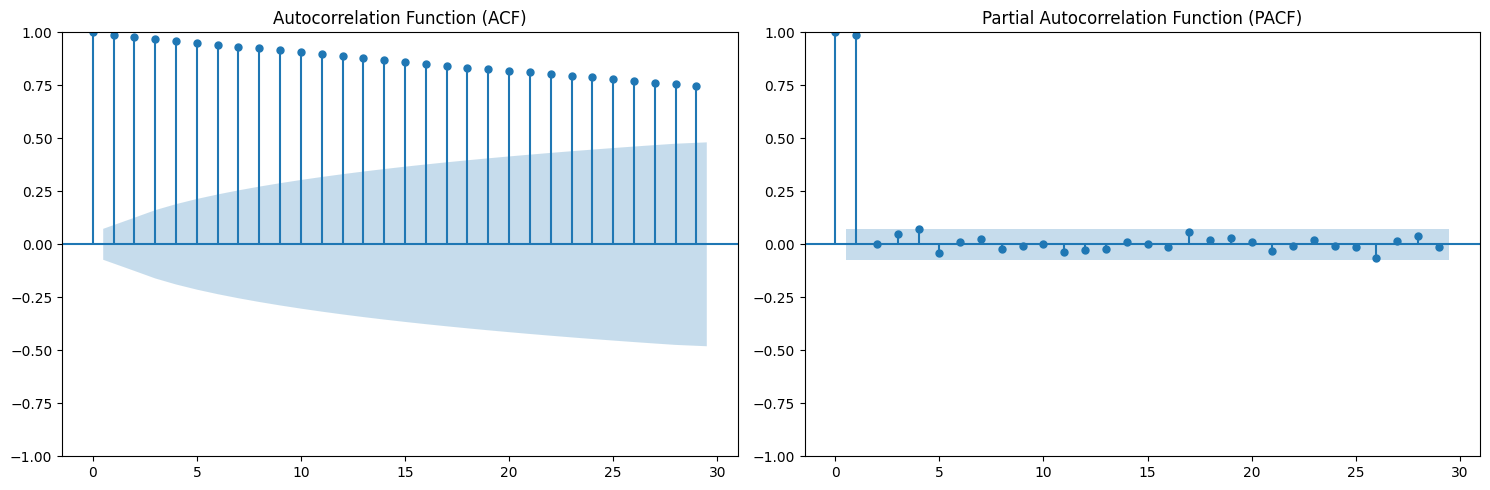

In [326]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(df_train_goc, ax=ax1)
plot_pacf(df_train_goc, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF)')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


In [289]:
vcb_diff = vcb.diff().dropna()
adf_test_diff = adfuller(vcb_diff)
print(f'p-value sau khi chênh lệch: {adf_test_diff[1]}')
if(adf_test_diff[1] > 0.05):
    print("Chuỗi chưa dừng, cần phải xử lý")
else:
    print("Chuỗi đã dừng, có thể sử dụng vào model")

p-value sau khi chênh lệch: 2.1286213567371078e-30
Chuỗi đã dừng, có thể sử dụng vào model


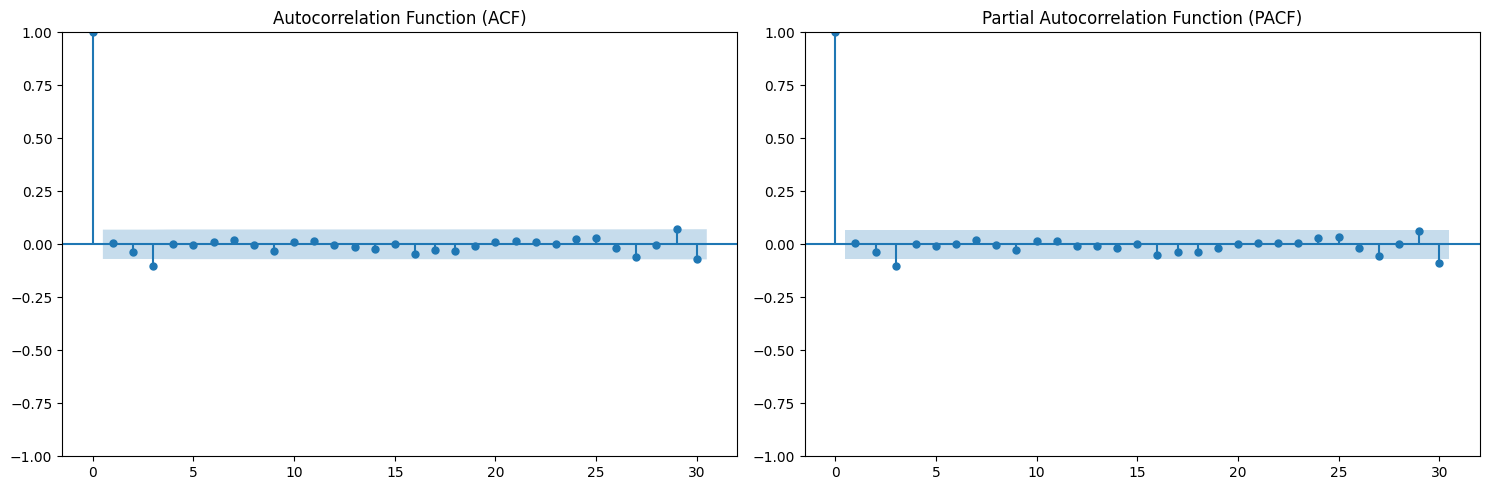

In [327]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(vcb_diff, ax=ax1)
plot_pacf(vcb_diff, ax=ax2)
ax1.set_title('Autocorrelation Function (ACF)')
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


### Xây dựng và huấn luyện mô hình SARIMA

In [291]:
train_size = int(len(vcb_diff) * 0.9)
df_train, df_test = vcb_diff[:train_size], vcb_diff[train_size:]

In [292]:
p, d, q = 0, 1, 1
P, D, Q, s = 0, 1, 1, 90

In [293]:
model_sarima = SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit_sarima = model_sarima.fit()

C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [294]:
forecast_diff = model_fit_sarima.forecast(steps=len(df_test))
print(forecast_diff)

720    -82.739109
721    968.204386
722   -226.734403
723   -441.918317
724    -54.698541
          ...    
796    391.176416
797    141.401637
798   -126.930437
799   -477.171559
800     57.736875
Name: predicted_mean, Length: 81, dtype: float64


C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [295]:
df_pre_goc = forecast_diff.cumsum() + df_train_goc.iloc[-1]
print(df_pre_goc)

720    86617.260891
721    87585.465278
722    87358.730875
723    86916.812558
724    86862.114017
           ...     
796    91931.331918
797    92072.733555
798    91945.803118
799    91468.631559
800    91526.368434
Name: predicted_mean, Length: 81, dtype: float64


In [296]:
print(R2(df_test, forecast_diff))
print(NSE(df_test, forecast_diff))
print(MAE(df_test, forecast_diff))
print(RMSE(df_test, forecast_diff))

0.0
1.0
897.9231001296355
1258.7651272602857


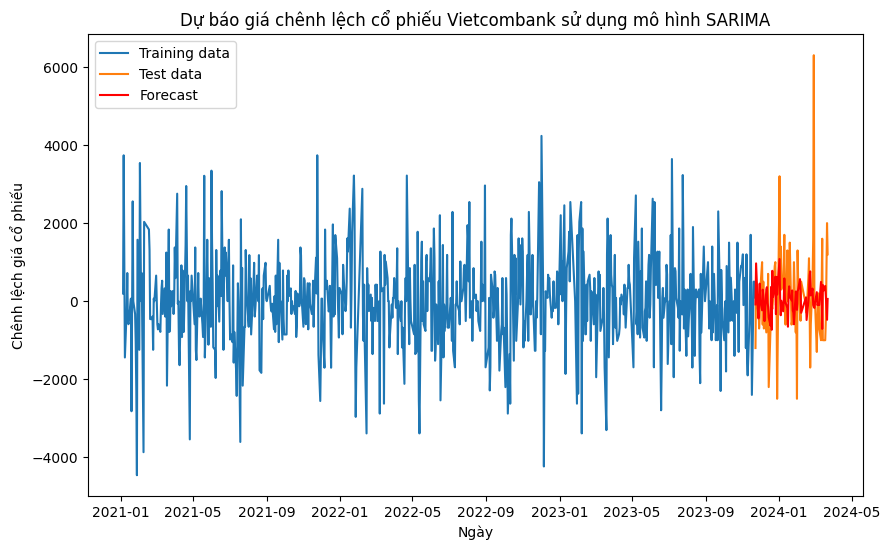

In [297]:
plt.figure(figsize=(10, 6))
plt.plot(df_train.index, df_train, label='Training data')
plt.plot(df_test.index, df_test, label='Test data')
plt.plot(df_test.index, forecast_diff, color='red', label='Forecast')
plt.title('Dự báo giá chênh lệch cổ phiếu Vietcombank sử dụng mô hình SARIMA')
plt.xlabel('Ngày')
plt.ylabel('Chênh lệch giá cổ phiếu')
plt.legend()
plt.show()

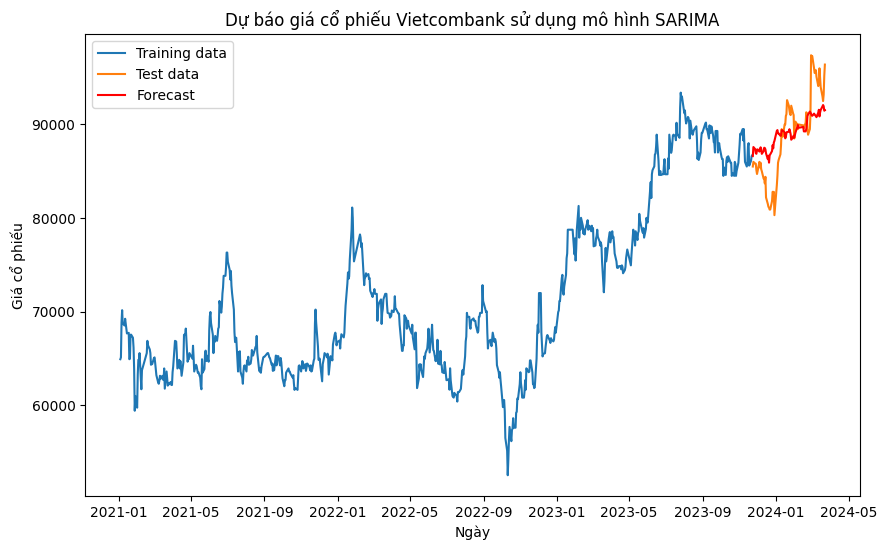

In [332]:
plt.figure(figsize=(10, 6))
plt.plot(df_train_goc.index, df_train_goc, label='Training data')
plt.plot(df_test_goc.index, df_test_goc, label='Test data')
plt.plot(df_test_goc.index, df_pre_goc, color='red', label='Forecast')
plt.title('Dự báo giá cổ phiếu Vietcombank sử dụng mô hình SARIMA')
plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()

In [299]:
print(model_fit_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              CLOSE   No. Observations:                  720
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 90)   Log Likelihood               -5411.540
Date:                            Wed, 01 May 2024   AIC                          10829.081
Time:                                    03:01:28   BIC                          10842.413
Sample:                                         0   HQIC                         10834.260
                                            - 720                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      1.149     -0.870      0.384      -3.252       1.252
ma.S.L90      -0.9903      1.172   

## Mô hình LSTM

### Đọc dữ liệu mã cổ phiếu Vietcombank giai đoạn từ năm 2121-2024

In [358]:
vcb = pd.read_csv("https://drive.google.com/uc?id=1Azg7G69cQdgPpocjuaOZiZnLOztwUU0q")
vcb['DATE'] = pd.to_datetime(vcb['DATE'], dayfirst= True)
vcb = vcb[::-1].reset_index(drop=True)
vcb.set_index('DATE', inplace=True)
vcb.head(10)

,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2021-01-04,64242.70,65422.67,63783.82,64898.24,907900.0
2021-01-05,64898.24,65947.10,64898.24,65094.90,1096230.0
2021-01-06,65226.01,69618.11,65094.90,68831.46,2080400.0
2021-01-07,68175.93,71125.84,68175.93,70142.54,1199800.0
2021-01-08,70798.08,70798.08,68503.69,68700.36,1000900.0
2021-01-11,68569.25,69290.34,68241.48,68503.69,847400.0
2021-01-12,69224.79,69224.79,68307.03,69224.79,842950.0
2021-01-13,69224.79,69552.55,68175.93,68700.36,1338200.0
2021-01-14,68831.46,68962.57,67717.05,68110.37,932200.0


In [359]:
data = vcb.filter(['CLOSE'])
dataset = data.values

training_data_len = int(np.ceil( len(dataset) * 0.8 ))
training_data_len

642

### Chuẩn hóa dữ liệu

In [360]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

### Xây dựng và huấn luyện mô hình LSTM

In [362]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data
x_train = []
y_train = []
#chia 60 diem du lieu va x train
# diem du lieu thu 61 vao y train
# hoc tu 60 diem du lieu truoc
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


[array([0.27616424, 0.28054399, 0.36375966, 0.39295828, 0.36083998,
       0.35646001, 0.37251938, 0.36083998, 0.34770051, 0.33748095,
       0.33894101, 0.27616424, 0.27762409, 0.33456126, 0.33456126,
       0.32726161, 0.3039028 , 0.25280544, 0.15353039, 0.1885686 ,
       0.16083005, 0.23966597, 0.27470418, 0.27470418, 0.29076333,
       0.20462775, 0.24988553, 0.29076333, 0.31996195, 0.30974239,
       0.29952305, 0.29076333, 0.26302477, 0.26448484, 0.26448484,
       0.27908393, 0.28054399, 0.26740452, 0.25134537, 0.23820612,
       0.22068691, 0.21776722, 0.22506666, 0.23674606, 0.22944663,
       0.23674606, 0.22798656, 0.22652672, 0.25426528, 0.20608782,
       0.24696562, 0.22944663, 0.21338725, 0.21922707, 0.21630716,
       0.22214697, 0.21484732, 0.21484732, 0.24550578, 0.25864503])]
[0.31996195279866524]

[array([0.27616424, 0.28054399, 0.36375966, 0.39295828, 0.36083998,
       0.35646001, 0.37251938, 0.36083998, 0.34770051, 0.33748095,
       0.33894101, 0.27616424, 0.27

In [363]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=16, epochs=10)

Epoch 1/10
37/37 [==============================] - 3s 22ms/step - loss: 0.0150
Epoch 2/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0037
Epoch 3/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0026
Epoch 4/10
37/37 [==============================] - 1s 21ms/step - loss: 0.0023
Epoch 5/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0022
Epoch 6/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0024
Epoch 7/10
37/37 [==============================] - 1s 21ms/step - loss: 0.0019
Epoch 8/10
37/37 [==============================] - 1s 21ms/step - loss: 0.0018
Epoch 9/10
37/37 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 10/10
37/37 [==============================] - 1s 21ms/step - loss: 0.0016


In [364]:

test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

r2 = R2(y_test, predictions)
nse = NSE(y_test, predictions)
mae = MAE(y_test, predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("R2: ", r2)
print("NSE: ", nse)
print("MAE: ", mae)
print("RMSE: ", rmse)


5/5 [==============================] - 1s 15ms/step
R2:  0.82456232342944
NSE:  0.3792449273707883
MAE:  2479.89521484375
RMSE:  2825.1263596048357


C:\Users\khenh\AppData\Local\Temp\ipykernel_28684\2527441821.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



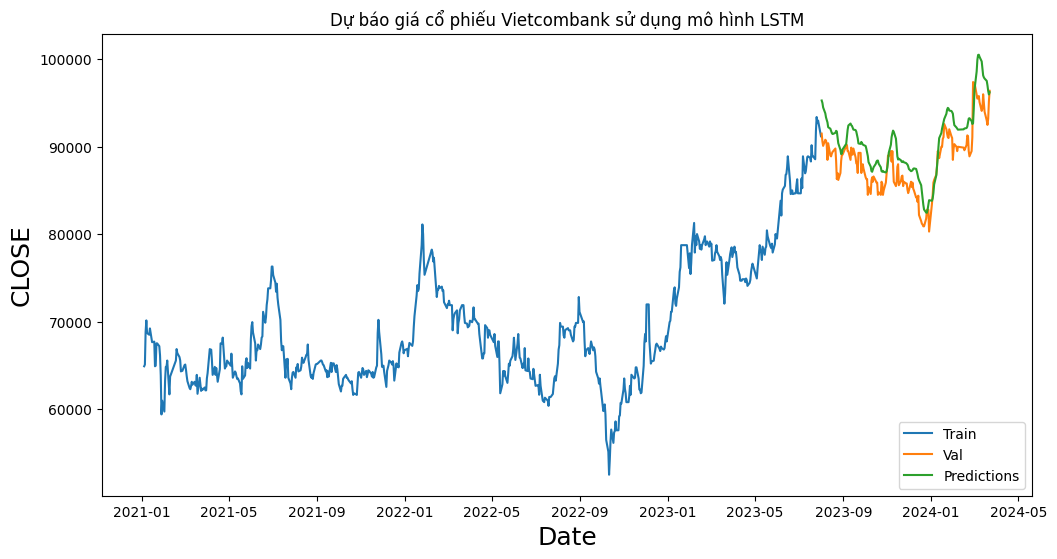

In [367]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(12,6))
plt.title('Dự báo giá cổ phiếu Vietcombank sử dụng mô hình LSTM')
plt.xlabel('Date', fontsize=18)
plt.ylabel('CLOSE', fontsize=18)
plt.plot(train['CLOSE'])
plt.plot(valid[['CLOSE', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

## Mô hình hồi quy tuyến tính

In [341]:
# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Đọc dữ liệu Vietcombank giai đoạn 2021-2024

In [342]:
df = pd.read_csv("https://drive.google.com/uc?id=1Azg7G69cQdgPpocjuaOZiZnLOztwUU0q")

df['DATE'] = pd.to_datetime(df['DATE'])
df = df[::-1].reset_index(drop=True)
df.set_index('DATE', inplace=True)
df = df.resample('D').last()
df.dropna(inplace=True)
df.head(10)

C:\Users\khenh\AppData\Local\Temp\ipykernel_28684\3259251544.py:3: UserWarning:

Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



,OPEN,HIGH,LOW,CLOSE,VOLUME
DATE,,,,,
2021-01-04,64242.70,65422.67,63783.82,64898.24,907900.0
2021-01-05,64898.24,65947.10,64898.24,65094.90,1096230.0
2021-01-06,65226.01,69618.11,65094.90,68831.46,2080400.0
2021-01-07,68175.93,71125.84,68175.93,70142.54,1199800.0
2021-01-08,70798.08,70798.08,68503.69,68700.36,1000900.0
2021-01-11,68569.25,69290.34,68241.48,68503.69,847400.0
2021-01-12,69224.79,69224.79,68307.03,69224.79,842950.0
2021-01-13,69224.79,69552.55,68175.93,68700.36,1338200.0
2021-01-14,68831.46,68962.57,67717.05,68110.37,932200.0


### Tính chỉ số cần thiết

In [343]:
df['EMA_9'] = df['CLOSE'].ewm(9).mean().shift()
df['SMA_5'] = df['CLOSE'].rolling(5).mean().shift()
df['SMA_10'] = df['CLOSE'].rolling(10).mean().shift()
df['SMA_15'] = df['CLOSE'].rolling(15).mean().shift()
df['SMA_30'] = df['CLOSE'].rolling(30).mean().shift()

In [344]:
def relative_strength_idx(df, n=14):

    delta = df['CLOSE'].shift(-1) - df['CLOSE']
    delta.dropna(inplace=True)
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)
fig = go.Figure(go.Scatter(x=df.index, y=df.RSI, name='RSI'))
fig.show()


In [345]:
EMA_12 = pd.Series(df['CLOSE'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['CLOSE'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [346]:
df = df.iloc[33:] #  moving averages and MACD line
df.dropna(inplace=True)

In [347]:
# Convert the dataframe to a numpy array
dataset = df.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .80 ))

training_data_len

615

### Xây dựng và huấn luyện mô hình Hồi quy tuyến tính

In [348]:
data_train = df[:training_data_len]
data_test = df[training_data_len:]

In [349]:
features = ['VOLUME','EMA_9', 'SMA_10', 'SMA_15', 'SMA_30', 'RSI', 'MACD', 'MACD_signal', 'OPEN', 'LOW', 'HIGH']
X = df[features]
y = df['CLOSE']

X_train = X[:training_data_len]
y_train = y[:training_data_len]
X_test = X[training_data_len:]
y_test = y[training_data_len:]

In [350]:

features = ['VOLUME','LOW', 'HIGH', 'OPEN']
X = df[features]
y = df['CLOSE']

X_train = X[:training_data_len]
y_train = y[:training_data_len]
X_test = X[training_data_len:]
y_test = y[training_data_len:]


In [351]:

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = R2(y_test, y_pred)
nse = NSE(y_test, y_pred)
mae = MAE(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("R2: ", r2)
print("NSE: ", nse)
print("MAE: ", mae)
print('Mean Squared Error:', mse)

R2:  0.9777051345692382
NSE:  0.9762034092299909
MAE:  436.77196103355055
Mean Squared Error: 303998.03653699066


C:\Users\khenh\AppData\Local\Temp\ipykernel_28684\1594221504.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Dự báo giá cổ phiếu Vietcombank sử dụng mô hình LR')

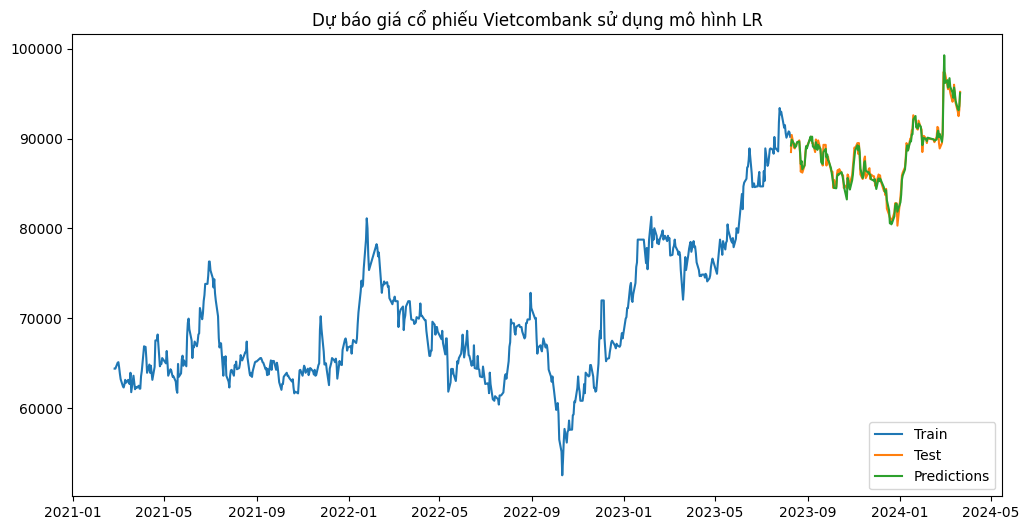

In [370]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
data_test['Predictions'] = y_pred
plt.plot(data_train['CLOSE'])
plt.plot(data_test[['CLOSE', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.title('Dự báo giá cổ phiếu Vietcombank sử dụng mô hình LR')

## Kết luận

1. Sau khi đã nghiên cứu và xây dựng các mô hình SARIMA, LSTM, LR thì mô hình cho ra kết quả tốt nhất để dự báo cho tập dữ liệu giá cổ phiếu Vietcombank chính là mô hình LR

2. Mô hình SARIMA chỉ có thể dự báo về tính xu hướng tiếp theo của giá cổ phiếu, nhưng không thể dự báo chính xác về giá của cổ phiếu bởi vì dữ liệu nó được học mang tính độc lập mặc cho dữ liệu về giá cổ phiếu luôn phụ thuộc vào yếu tố tự nhiên: kinh tế, dịch bệnh, chính sách của các quốc gia...

3. Mô hình LSTM đã có kết quả khá cao mặc dù chỉ sử dụng dữ liệu từ chính nó để dự đoán.

4. Mô hình LR mặc dù đưa ra kết quả dự đoán rất cao nhưng mô hình này chỉ có thể dự báo tốt trên tập dữ liệu Test mà không thể dự báo được dữ liệu tương lai. Bởi vì những dữ liệu nó được học đòi hỏi phải có trước thời điểm nó dự đoán. Đây cũng là một trong những lí do khiến cho kết quả của mô hình đạt cao hơn mức kì vọng.

==> Từ các ý trên mô hình có thể dự báo được dữ liệu giá cổ phiếu trong tương lai đó là LSTM

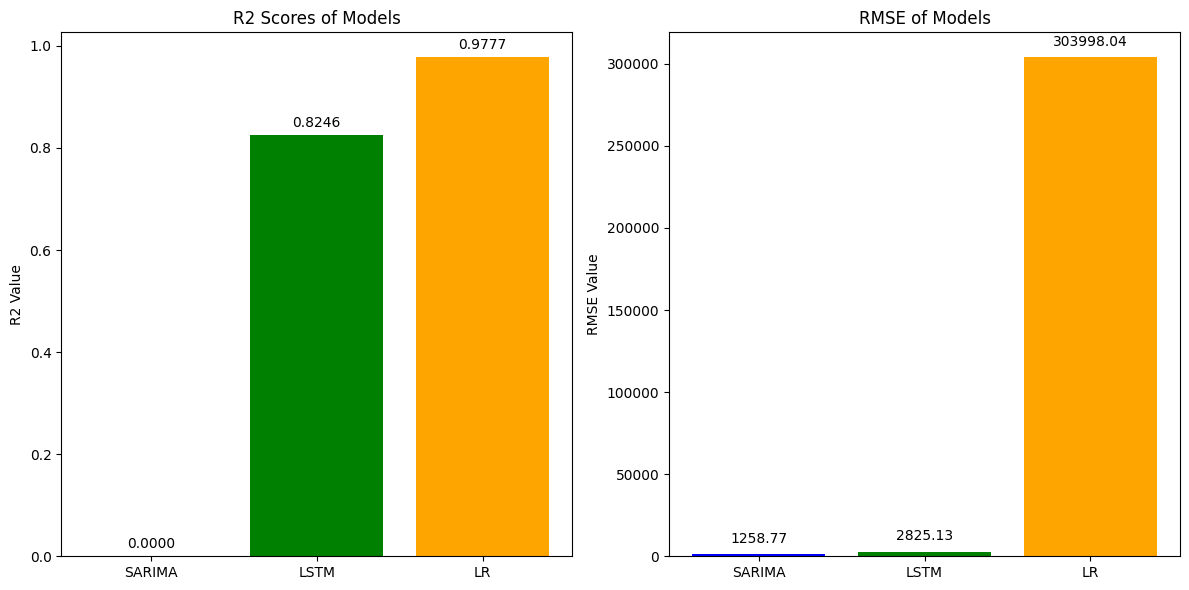

In [378]:
import numpy as np
import matplotlib.pyplot as plt

# Tên các mô hình
models = ['SARIMA', 'LSTM', 'LR']

# Độ đo của mỗi mô hình
r2_values = [0.0, 0.82456232342944, 0.9777051345692382]
rmse_values = [1258.7651272602857, 2825.1263596048357, 303998.03653699066]

# Màu sắc của mỗi mô hình
colors = ['blue', 'green', 'orange']

# Tạo biểu đồ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Vẽ biểu đồ R2
bars1 = ax1.bar(models, r2_values, color=colors)
ax1.set_title('R2 Scores of Models')
ax1.set_ylabel('R2 Value')

# Hiển thị giá trị trên cột cho R2
for bar, value in zip(bars1, r2_values):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, '{:.4f}'.format(value), ha='center', va='bottom')

# Vẽ biểu đồ RMSE
bars2 = ax2.bar(models, rmse_values, color=colors)
ax2.set_title('RMSE of Models')
ax2.set_ylabel('RMSE Value')

# Hiển thị giá trị trên cột cho RMSE
for bar, value in zip(bars2, rmse_values):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5000, '{:.2f}'.format(value), ha='center', va='bottom')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()
